In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from pathlib import Path
sns.set()
sns.set_palette('colorblind');

In [95]:
logfile = '/data/logs/2018-03-20-1825-bigmodel-b3/bigmodel_mlp_nolim/run_5/rep{:02}/logall_35999.txt'

In [96]:
i = 0
ok = True
logs = []
while ok:
    try:
        logs.append(pd.read_csv(logfile.format(i), delimiter="\t"))
    except:
        ok = False
    else:
        i += 1
log = pd.concat(logs)
    
log.query('onOpp == 1').mean()

eval            0.000000
iter         2503.574781
id             14.285479
a               5.340095
onOpp           1.000000
nbOnOpp         1.958838
curCoop         2.025441
meanOwn         2.082811
meanTotal       3.430882
dtype: float64

In [97]:
on_opp = log.query('onOpp == 1 and nbOnOpp == 2')
on_opp.head(10)

,eval,iter,id,a,onOpp,nbOnOpp,curCoop,meanOwn,meanTotal
431,0,14,11,3.94266,1,2,4.230290,4.230290,8.308920
446,0,14,26,5.47131,1,2,4.078630,4.251390,5.308970
461,0,15,11,3.94266,1,2,0.006251,2.118270,4.227880
472,0,15,22,2.78273,1,2,0.140598,0.140598,0.146849
521,0,17,11,3.94266,1,2,0.134363,1.134220,2.404680
536,0,17,26,5.47131,1,2,0.143973,0.118050,0.581485
583,0,19,13,3.46964,1,2,4.141640,4.144370,4.355530
591,0,19,21,3.57919,1,2,2.111560,2.111560,6.253200
613,0,20,13,3.46964,1,2,3.847600,4.114320,4.326150
621,0,20,21,3.57919,1,2,0.006752,1.059160,5.053780


3.194011254371562


3.5

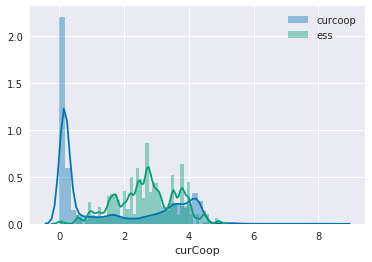

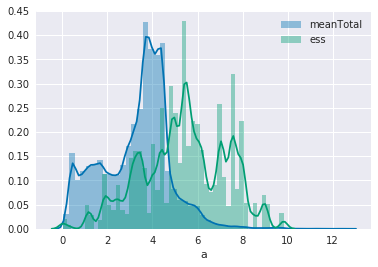

In [98]:
sns.distplot(on_opp['curCoop'], label="curcoop")
sns.distplot(on_opp['a']/on_opp['nbOnOpp'], label="ess")
plt.legend()
plt.figure()
sns.distplot(on_opp['meanTotal'], label="meanTotal")
sns.distplot(on_opp['a'], label="ess")
plt.legend()
print(on_opp['curCoop'].mean() * 2)
(5*0.7)


In [99]:
print(scipy.stats.normaltest(on_opp['curCoop']))
print(scipy.stats.normaltest(on_opp['a']))

NormaltestResult(statistic=9321.546243104205, pvalue=0.0)
NormaltestResult(statistic=3009.4580398829103, pvalue=0.0)


Not normal, so wilcoxon

In [100]:
scipy.stats.wilcoxon(on_opp['curCoop'], on_opp['a']/on_opp['nbOnOpp'])

WilcoxonResult(statistic=4086449929.0, pvalue=0.0)

In [101]:
on_opp['curCoop'].median(), (on_opp['a']/on_opp['nbOnOpp']).median()

(0.464382, 2.713995)

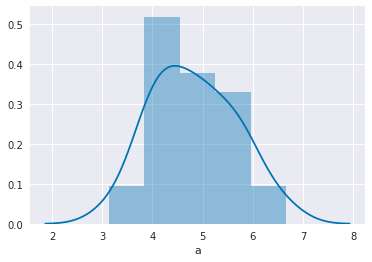

In [83]:
sns.distplot(log.groupby('id').mean()['a'])